In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import numpy as np
import warnings
import statsmodels.api as sm
import pmdarima as pm
import itertools as itr

from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing as HWES
warnings.filterwarnings('ignore')

# Import Data

In [2]:
df = pd.read_excel('candy_production.xlsx')
# pd.reset_option('display.max_rows')
df=df.rename(columns={'observation_date': 'Waktu', 'IPG3113N': 'Jumlah Produksi'})
df['Waktu'] = pd.to_datetime(df['Waktu'])
df['Bulan'] = df['Waktu'].dt.strftime('%B')
df['Year'] = df['Waktu'].dt.year.astype(str)
df

,Waktu,Jumlah Produksi,Bulan,Year
0,2006-01-01,1182816,January,2006
1,2006-02-01,1178165,February,2006
2,2006-03-01,1084194,March,2006
3,2006-04-01,1075783,April,2006
4,2006-05-01,1019894,May,2006
...,...,...,...,...
127,2016-08-01,1046977,August,2016
128,2016-09-01,1093191,September,2016
129,2016-10-01,1190502,October,2016
130,2016-11-01,1168431,November,2016


In [3]:
df[['Jumlah Produksi']].describe()

,Jumlah Produksi
count,1.320000e+02
mean,1.044286e+06
std,1.261456e+05
min,7.956510e+05
25%,9.368075e+05
50%,1.027304e+06
75%,1.159216e+06
max,1.320261e+06


# Data Preprocessing

## Analisis Pola Data

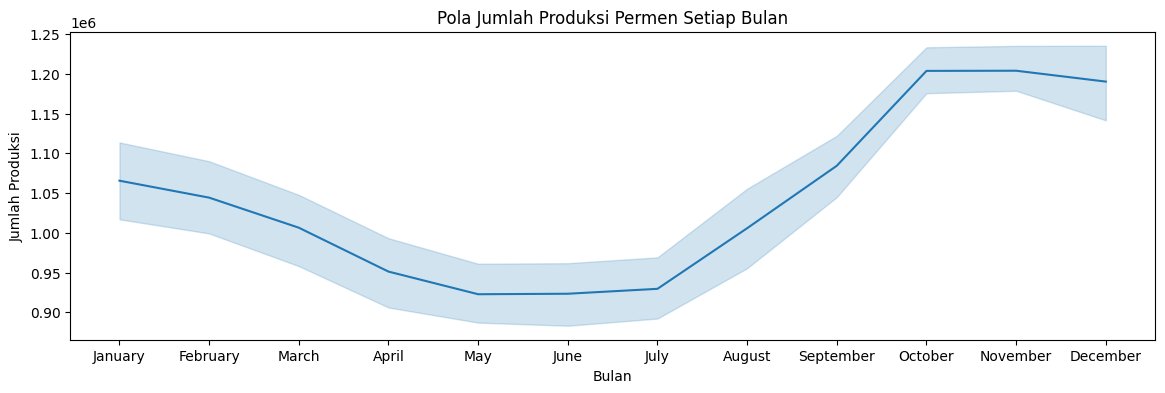

In [4]:
sns.lineplot(data=df, x='Bulan', y='Jumlah Produksi').set(title="Pola Jumlah Produksi Permen Setiap Bulan")
plt.gcf().set_size_inches(14, 4)

## Check Outlier

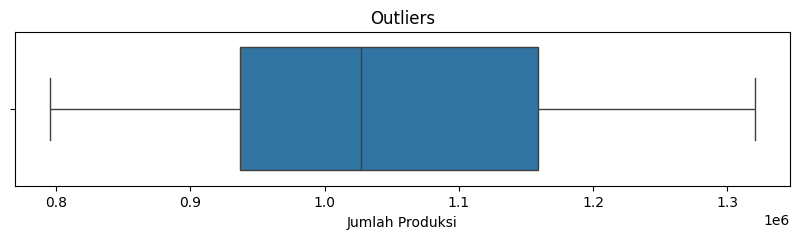

In [5]:
plt.figure(figsize=(10, 2))
sns.boxplot(x=df['Jumlah Produksi'])

# Set plot labels and title
plt.xlabel('Jumlah Produksi')
plt.title('Outliers')

plt.show()

## Dekomposisi

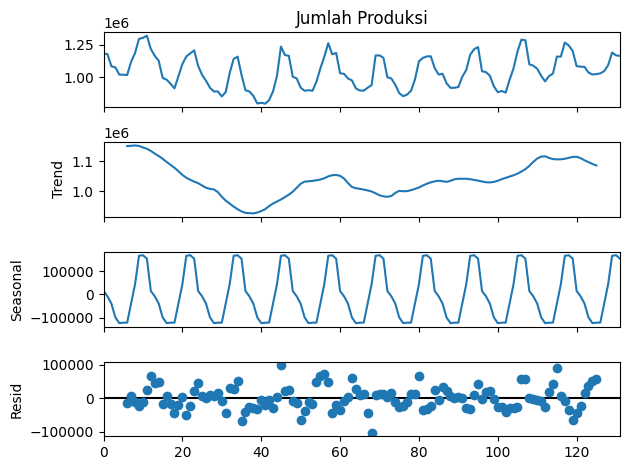

In [6]:
# Melakukan decomposisi dengan metode additive
result = seasonal_decompose(df['Jumlah Produksi'], model='additive', period=12)

# Menampilkan hasil decomposisi
result.plot()
plt.show()

# Applying Model's 1 (Naive)

In [7]:
dt = df['Jumlah Produksi'].reset_index()
data = dt['Jumlah Produksi']
n = len(data)

## Naive Seasonal Pendek

In [8]:
# Model Naive Musiman
def naive_seasonal_forecast_pendek(data, seasonal_period_pendek):

    predictions = []

    for i in range(seasonal_period_pendek, len(data)):
        predictions.append(data[i - seasonal_period_pendek])

    return predictions

In [9]:
seasonal_period_pendek = 12  # Periode musiman (dalam kasus ini, 6)
naive_seasonal_predictions_pendek = naive_seasonal_forecast_pendek(data, seasonal_period_pendek)

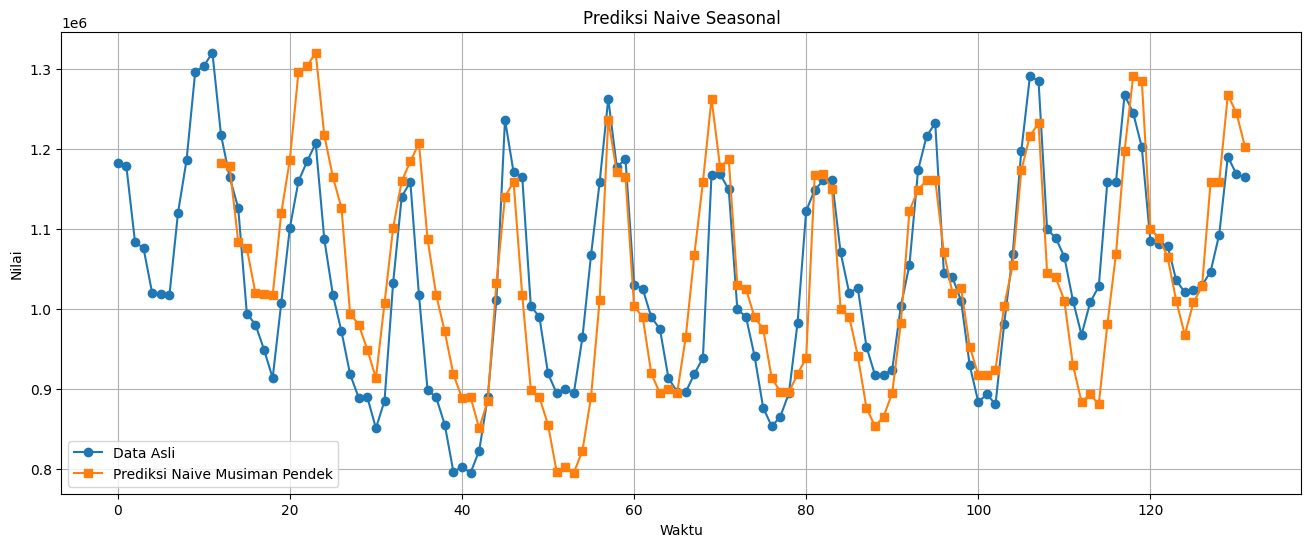

In [10]:
plt.figure(figsize=(16, 6))
plt.plot(data, label='Data Asli', marker='o')
plt.plot(range(seasonal_period_pendek, n), naive_seasonal_predictions_pendek, label='Prediksi Naive Musiman Pendek', marker='s')
plt.xlabel('Waktu')
plt.ylabel('Nilai')
plt.title('Prediksi Naive Seasonal')
plt.legend()
plt.grid(True)
plt.show()

## Naive Seasonal Panjang

In [11]:
# Model Naive Musiman
def naive_seasonal_forecast_panjang(data, seasonal_period_panjang):

    predictions = []

    for i in range(seasonal_period_panjang, len(data)):
        predictions.append(data[i - seasonal_period_panjang])

    return predictions

In [12]:
seasonal_period_panjang = 24  # Periode musiman (dalam kasus ini, 12)
naive_seasonal_predictions_panjang = naive_seasonal_forecast_panjang(data, seasonal_period_panjang)

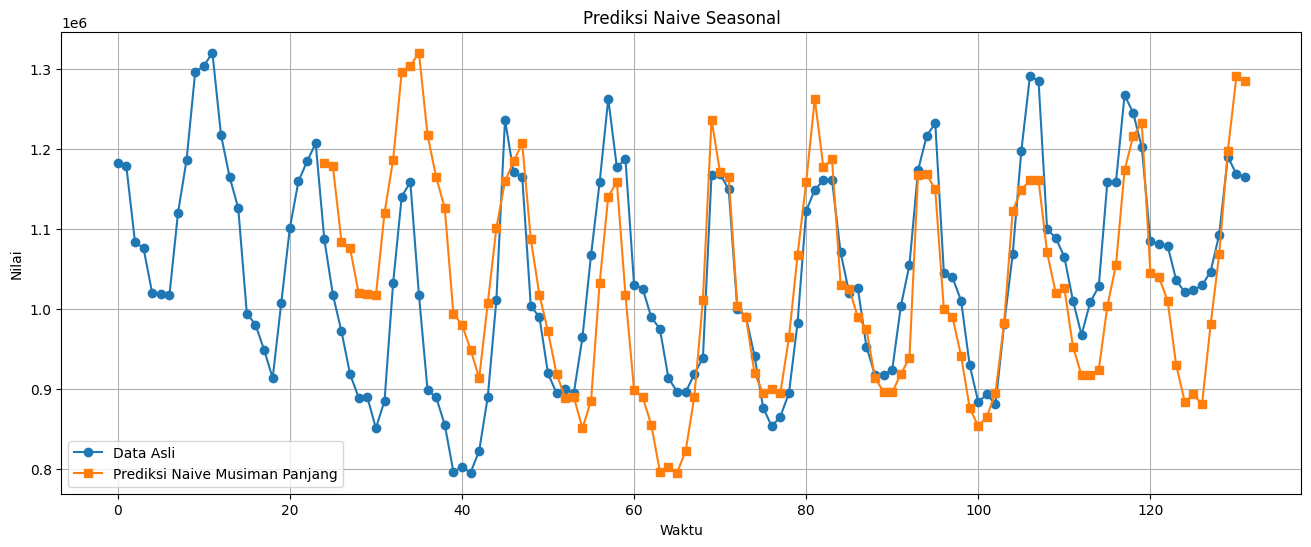

In [13]:
plt.figure(figsize=(16, 6))
plt.plot(data, label='Data Asli', marker='o')
plt.plot(range(seasonal_period_panjang, n), naive_seasonal_predictions_panjang, label='Prediksi Naive Musiman Panjang', marker='s')
plt.xlabel('Waktu')
plt.ylabel('Nilai')
plt.title('Prediksi Naive Seasonal')
plt.legend()
plt.grid(True)
plt.show()

## Gabungan Naive Pendek & Panjang

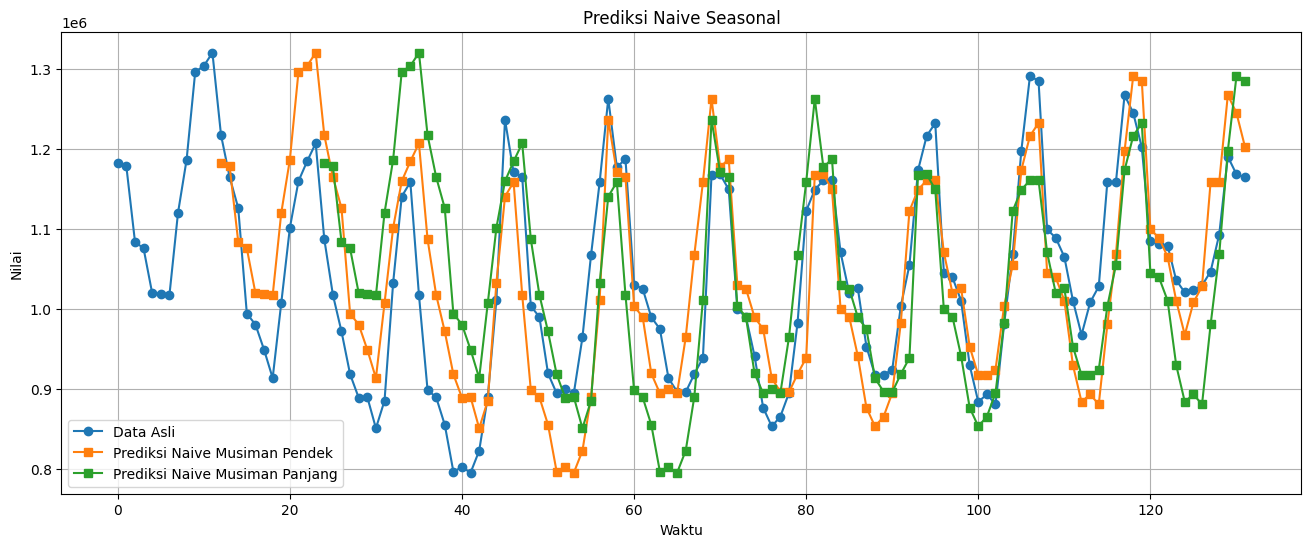

In [14]:
plt.figure(figsize=(16, 6))
plt.plot(data, label='Data Asli', marker='o')
plt.plot(range(seasonal_period_pendek, n), naive_seasonal_predictions_pendek, label='Prediksi Naive Musiman Pendek', marker='s')
plt.plot(range(seasonal_period_panjang, n), naive_seasonal_predictions_panjang, label='Prediksi Naive Musiman Panjang', marker='s')
plt.xlabel('Waktu')
plt.ylabel('Nilai')
plt.title('Prediksi Naive Seasonal')
plt.legend()
plt.grid(True)
plt.show()

## Naive Seasonal Evaluation

### Mean Square Error (MSE)

In [15]:
def calculate_squared_error(predictions, actual_data):
    
    squared_errors = [(predictions[i] - actual_data[i]) ** 2 for i in range(len(predictions))]
    
    return squared_errors

# Mengonversi data ke dalam array NumPy
data_array = data.values

In [16]:
# Menghitung Selisih antara Prediksi dan Data Asli
squared_errors_seasonal1 = calculate_squared_error(naive_seasonal_predictions_pendek, data_array[seasonal_period_pendek:])
squared_errors_seasonal2 = calculate_squared_error(naive_seasonal_predictions_panjang, data_array[seasonal_period_panjang:])

In [17]:
mse_seasonal1 = np.mean(squared_errors_seasonal1)
mse_seasonal2 = np.mean(squared_errors_seasonal2)

In [18]:
print(f"MSE Naive Musiman Pendek: {mse_seasonal1:.2f}")
print(f"MSE Naive Musiman Panjang {mse_seasonal2:.2f}")

MSE Naive Musiman Pendek: 7055476955.53
MSE Naive Musiman Panjang 11845163051.74


### Root Mean Square Error (RMSE)

In [19]:
def calculate_rmse(actual, forecast):
    n = len(actual)
    
    if n != len(forecast):
        raise ValueError("Panjang actual dan forecast harus sama")
    
    squared_errors = [(actual[i] - forecast[i])**2 for i in range(n)]
    mean_squared_error = np.mean(squared_errors)
    
    rmse = np.sqrt(mean_squared_error)
    
    return rmse

In [20]:
# Menghitung RMSE
rmse_seasonal1 = calculate_rmse(data[12:].reset_index(drop=True), naive_seasonal_predictions_pendek)
rmse_seasonal2 = calculate_rmse(data[24:].reset_index(drop=True), naive_seasonal_predictions_panjang)

In [21]:
print(f"RMSE Naive Musiman Pendek: {rmse_seasonal1:.2f}")
print(f"RMSE Naive Musiman Panjang: {rmse_seasonal2:.2f}")

RMSE Naive Musiman Pendek: 83996.89
RMSE Naive Musiman Panjang: 108835.49


### Mean Absolute Percentage Error (MAPE)



In [22]:
def calculate_mape(actual, forecast):
    n = len(actual)
    
    if n != len(forecast):
        raise ValueError("Panjang actual dan forecast harus sama")
    
    absolute_errors = [abs((actual[i] - forecast[i])/actual[i]) for i in range(n)]
    sum_absolute_errors = sum(absolute_errors)
    
    mape = (sum_absolute_errors) * 100 / n
    
    return mape

In [23]:
# Menghitung MAPE
mape_seasonal1 = calculate_mape(data[12:].reset_index(drop=True), naive_seasonal_predictions_pendek)
mape_seasonal2 = calculate_mape(data[24:].reset_index(drop=True), naive_seasonal_predictions_panjang)

In [24]:
print(f"MAPE Naive Musiman Pendek: {mape_seasonal1:.2f} %")
print(f"MAPE Naive Musiman Panjang: {mape_seasonal2:.2f} %")

MAPE Naive Musiman Pendek: 6.76 %
MAPE Naive Musiman Panjang: 8.57 %


### Hasil Evaluasi Naive

In [25]:
dataeval = [
    ["Naive Seasonal Pendek", "{:.2f}".format(mse_seasonal1),
    "{:.2f}".format(rmse_seasonal1),"{:.2f}".format(mape_seasonal1)],
    
    ["Naive Seasonal Panjang", "{:.2f}".format(mse_seasonal2),
    "{:.2f}".format(rmse_seasonal2),"{:.2f}".format(mape_seasonal2)]
]

evals1 = pd.DataFrame(dataeval, columns=["Model", "MSE", "RMSE", "MAPE  %"])

In [26]:
evals1

,Model,MSE,RMSE,MAPE %
0,Naive Seasonal Pendek,7055476955.53,83996.89,6.76
1,Naive Seasonal Panjang,11845163051.74,108835.49,8.57


# Moving Average

## Moving Average

### Jangka Panjang

In [27]:
# Menghitung MA(6)
ma6 = []

for i in range(len(df)):
    
    if i >= 6:
        ma6_value = (data[i-1] + data[i-2] + data[i-3] + data[i-4] + data[i-5] + data[i-6]) / 6
    else:
        ma6_value = np.nan
    
    ma6.append(ma6_value)

In [28]:
# Membuat DataFrame
moving_average_6 = {'Tanggal':df.index,'Aktual':data,'MA(6)': ma6}
df_moving_average_6 = pd.DataFrame(moving_average_6)
df_moving_average_6_clean = df_moving_average_6.dropna()
df_moving_average_6_clean.reset_index(inplace=True)
df_moving_average_6_clean[['Aktual','MA(6)']]


,Aktual,MA(6)
0,1017114,1.093380e+06
1,1120216,1.065762e+06
2,1186654,1.056104e+06
3,1296397,1.073181e+06
4,1303710,1.109950e+06
...,...,...
121,1046977,1.045213e+06
122,1093191,1.039491e+06
123,1190502,1.041786e+06
124,1168431,1.067507e+06


In [29]:
ma12 = []

for i in range(len(df)):
    
    if i >= 3:
        ma12_value = (data[i-1] + data[i-2] + data[i-3])/ 3
    else:
        ma12_value = np.nan
    
    ma12.append(ma12_value)

In [30]:
# Membuat DataFrame
moving_average_12 = {'Tanggal':df.index,'Aktual':data,'MA(12)': ma12}
df_moving_average_12 = pd.DataFrame(moving_average_12)
df_moving_average_12_clean = df_moving_average_12.dropna()
df_moving_average_12_clean[['Aktual','MA(12)']]

,Aktual,MA(12)
3,1075783,1.148392e+06
4,1019894,1.112714e+06
5,1019425,1.059957e+06
6,1017114,1.038367e+06
7,1120216,1.018811e+06
...,...,...
127,1046977,1.024791e+06
128,1093191,1.033511e+06
129,1190502,1.056560e+06
130,1168431,1.110223e+06


In [31]:
# Membuat DataFrame
moving_average = {'Tanggal':df.index,'aktual':data, 'MA(6)': ma6,'MA(12)': ma12}
df_moving_average = pd.DataFrame(moving_average)
df_moving_average[['aktual','MA(6)','MA(12)']]

,aktual,MA(6),MA(12)
0,1182816,NaN,NaN
1,1178165,NaN,NaN
2,1084194,NaN,NaN
3,1075783,NaN,1.148392e+06
4,1019894,NaN,1.112714e+06
...,...,...,...
127,1046977,1.045213e+06,1.024791e+06
128,1093191,1.039491e+06,1.033511e+06
129,1190502,1.041786e+06,1.056560e+06
130,1168431,1.067507e+06,1.110223e+06


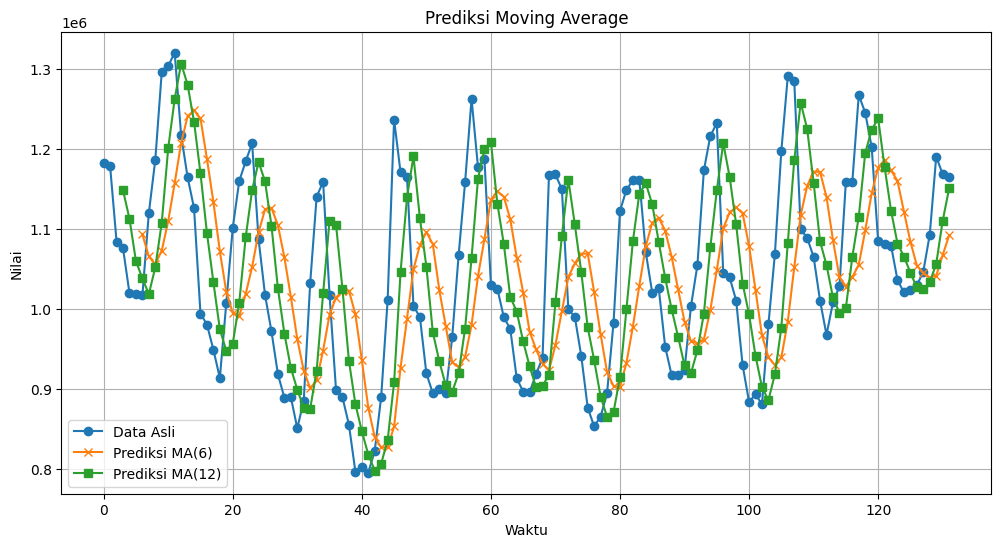

In [32]:
data = df_moving_average['aktual']
n = len(data)

# Plot data asli dan prediksi Naive
plt.figure(figsize=(12, 6))
plt.plot(data, label='Data Asli', marker='o')
plt.plot(range(0, n), df_moving_average['MA(6)'], label='Prediksi MA(6)', marker='x')
plt.plot(range(0, n), df_moving_average['MA(12)'], label='Prediksi MA(12)', marker='s')
plt.xlabel('Waktu')
plt.ylabel('Nilai')
plt.title('Prediksi Moving Average')
plt.legend()
plt.grid(True)
plt.show()


In [33]:
df_MA6 = df_moving_average_6_clean.reset_index(drop = True)
df_MA12 = df_moving_average_12_clean.reset_index(drop = True)

In [34]:
# Menghitung Selisih antara Prediksi dan Data Asli
def calculate_mse(predictions, actual_data):
    
    squared_errors = []
    
    for i in range(len(predictions)):
        error = predictions[i] - actual_data[i]
        squared_errors.append(error ** 2)
        
    return squared_errors

In [35]:
squared_errors_ma6 = calculate_mse(df_MA6['MA(6)'], df_MA6['Aktual'])
squared_errors_ma12 = calculate_mse(df_MA12['MA(12)'], df_MA12['Aktual'])

In [36]:
# Menghitung MSE
mse_ma6 = np.mean(squared_errors_ma6)
mse_ma12 = np.mean(squared_errors_ma12)

In [37]:
print(f"MSE Moving Average (6): {mse_ma6:.2f}")
print(f"MSE Moving Average (12) {mse_ma12:.2f}")

MSE Moving Average (6): 21173812369.96
MSE Moving Average (12) 12802861988.31


In [38]:
def calculate_rmse(actual, forecast):
    n = len(actual)
    
    if n != len(forecast):
        raise ValueError("Panjang actual dan forecast harus sama")
    
    squared_errors = [(actual[i] - forecast[i])**2 for i in range(n)]
    mean_squared_error = sum(squared_errors) / n
    
    rmse = mean_squared_error**0.5
    
    return rmse

In [39]:
# Menghitung RMSE
rmse_ma6 = calculate_rmse(df_MA6['Aktual'], df_MA6['MA(6)'])
rmse_ma12 = calculate_rmse(df_MA12['Aktual'], df_MA12['MA(12)'])

In [40]:
# Menampilkan nilai RMSE
print(f"RMSE Moving Average (6): {rmse_ma6:.2f}")
print(f"RMSE Moving Average (12): {rmse_ma12:.2f}")

RMSE Moving Average (6): 145512.24
RMSE Moving Average (12): 113149.73


In [41]:
def calculate_mape(actual, forecast):
    n = len(actual)
    
    if n != len(forecast):
        raise ValueError("Panjang actual dan forecast harus sama")
    
    absolute_errors = [abs((actual[i] - forecast[i])/actual[i]) for i in range(n)]
    sum_absolute_errors = sum(absolute_errors)
    
    mape = (sum_absolute_errors) * 100 / n
    
    return mape

In [42]:
# Menghitung MAD
mape_ma6 = calculate_mape(df_MA6['Aktual'], df_MA6['MA(6)'])
mape_ma12 = calculate_mape(df_MA12['Aktual'], df_MA12['MA(12)'])

In [43]:
# Menampilkan nilai MAD
print(f"MAPE Moving Average (6): {mape_ma6:.2f} %")
print(f"MAPE Moving Average (12): {mape_ma12:.2f} %")

MAPE Moving Average (6): 12.14 %
MAPE Moving Average (12): 9.11 %


In [44]:
dataeval2 = [
    ["Moving Average (6)", "{:.2f}".format(mse_ma6), "{:.2f}".format(rmse_ma6), "{:.2f}".format(mape_ma6)],
    
    ["Moving Average (12)", "{:.2f}".format(mse_ma12), "{:.2f}".format(rmse_ma12), "{:.2f}".format(mape_ma12)]
]
evals2 = pd.DataFrame(dataeval2, columns=["Model", "MSE", "RMSE", "MAPE %" ])
evals2

,Model,MSE,RMSE,MAPE %
0,Moving Average (6),21173812369.96,145512.24,12.14
1,Moving Average (12),12802861988.31,113149.73,9.11


# SARIMAX 

In [45]:
df

,Waktu,Jumlah Produksi,Bulan,Year
0,2006-01-01,1182816,January,2006
1,2006-02-01,1178165,February,2006
2,2006-03-01,1084194,March,2006
3,2006-04-01,1075783,April,2006
4,2006-05-01,1019894,May,2006
...,...,...,...,...
127,2016-08-01,1046977,August,2016
128,2016-09-01,1093191,September,2016
129,2016-10-01,1190502,October,2016
130,2016-11-01,1168431,November,2016


In [46]:
# Mengubah kolom 'date' menjadi datetime
df['Waktu'] = pd.to_datetime(df['Waktu'])

df['Bulan'] = df['Waktu'].dt.month

# Mengatur kolom 'date' sebagai indeks
df.set_index('Waktu', inplace=True)
df=df[['Jumlah Produksi', 'Bulan']]
df

,Jumlah Produksi,Bulan
Waktu,,
2006-01-01,1182816,1
2006-02-01,1178165,2
2006-03-01,1084194,3
2006-04-01,1075783,4
2006-05-01,1019894,5
...,...,...
2016-08-01,1046977,8
2016-09-01,1093191,9
2016-10-01,1190502,10


In [47]:
# Membuat dummy variabel bulan
df = pd.get_dummies(df, columns=['Bulan'])

In [48]:
# Menambahkan variabel tren
df['Trend'] = np.arange(1, len(df)+1)
df

,Jumlah Produksi,Bulan_1,Bulan_2,Bulan_3,Bulan_4,Bulan_5,Bulan_6,Bulan_7,Bulan_8,Bulan_9,Bulan_10,Bulan_11,Bulan_12,Trend
Waktu,,,,,,,,,,,,,,
2006-01-01,1182816,True,False,False,False,False,False,False,False,False,False,False,False,1
2006-02-01,1178165,False,True,False,False,False,False,False,False,False,False,False,False,2
2006-03-01,1084194,False,False,True,False,False,False,False,False,False,False,False,False,3
2006-04-01,1075783,False,False,False,True,False,False,False,False,False,False,False,False,4
2006-05-01,1019894,False,False,False,False,True,False,False,False,False,False,False,False,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-08-01,1046977,False,False,False,False,False,False,False,True,False,False,False,False,128
2016-09-01,1093191,False,False,False,False,False,False,False,False,True,False,False,False,129
2016-10-01,1190502,False,False,False,False,False,False,False,False,False,True,False,False,130


In [49]:
train_data_panjang = df.iloc[:79]
test_data_panjang = df.iloc[79:]

In [50]:
# Membuat model regresi linear dengan scikit-learn
X_train = train_data_panjang[['Trend'] + [col for col in df.columns if 'month' in col]]
y_train = train_data_panjang['Jumlah Produksi']
model_sm_panjang = sm.OLS(y_train, X_train.astype(float)).fit()
model_sm_panjang.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:        Jumlah Produksi   R-squared (uncentered):                   0.705
Model:                            OLS   Adj. R-squared (uncentered):              0.701
Method:                 Least Squares   F-statistic:                              186.6
Date:                Tue, 02 Jan 2024   Prob (F-statistic):                    2.17e-22
Time:                        23:39:58   Log-Likelihood:                         -1157.8
No. Observations:                  79   AIC:                                      2318.
Df Residuals:                      78   BIC:                                      2320.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Trend       1.884e+04   1379.249     13.662      0.000    1.61e+04    2.16e+04
==============================================================================
Omnibus:                       11.358   Durbin-Watson:                   0.020
Prob(Omnibus):                  0.003   Jarque-Bera (JB):                3.673
Skew:                           0.134   Prob(JB):                        0.159
Kurtosis:                       1.978   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
# Membuat prediksi untuk data test
Y_test = test_data_panjang[['Trend'] + [col for col in df.columns if 'month' in col]]
test_data_panjang['Predictions'] = model_sm_panjang.predict(Y_test)

In [52]:
#residual dari time series regression
residual = model_sm_panjang.resid
len(residual)

resid_panjang = pd.DataFrame(residual)
resid_panjang = resid_panjang.rename(columns={0: 'resid_panjang'})
resid_panjang

,resid_panjang
Waktu,
2006-01-01,1.163973e+06
2006-02-01,1.140479e+06
2006-03-01,1.027665e+06
2006-04-01,1.000410e+06
2006-05-01,9.256782e+05
...,...
2012-03-01,-4.717530e+05
2012-04-01,-5.551301e+05
2012-05-01,-5.974133e+05


In [53]:
from statsmodels.tsa import stattools
adf_result = stattools.adfuller(resid_panjang, autolag='AIC')

print(f'p-val of the ADF test: {adf_result}')
if adf_result[1]<0.05:
    print('data stasioner')
else:
    print('data tidak stasioner')

p-val of the ADF test: (-1.371256560826656, 0.5959759041773472, 12, 66, {'1%': -3.5335601309235605, '5%': -2.9064436883991434, '10%': -2.590723948576676}, 1634.3706763035646)
data tidak stasioner


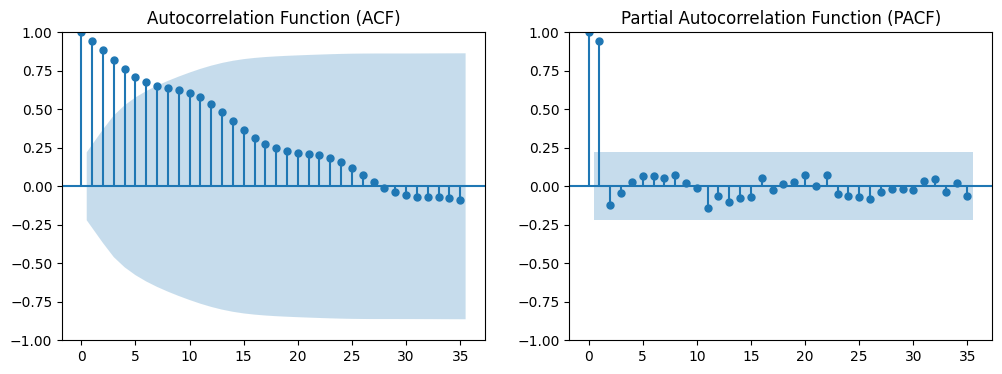

In [54]:
acfresult = sm.tsa.acf(resid_panjang,fft=False)
pacfresult = sm.tsa.pacf(resid_panjang,method='ols')

sl=0.05
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

sm.graphics.tsa.plot_acf(resid_panjang, lags=35, alpha=sl, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

# PACF plot with significant lines 
sm.graphics.tsa.plot_pacf(resid_panjang, lags=35, alpha=sl, ax=ax2) 
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout
plt.show()

In [55]:
# Diferensiasi sederhana
resid_panjang['Diff'] = resid_panjang['resid_panjang'].diff(1)
resid_panjang['Diff12'] = resid_panjang['resid_panjang'].diff(1).diff(12)

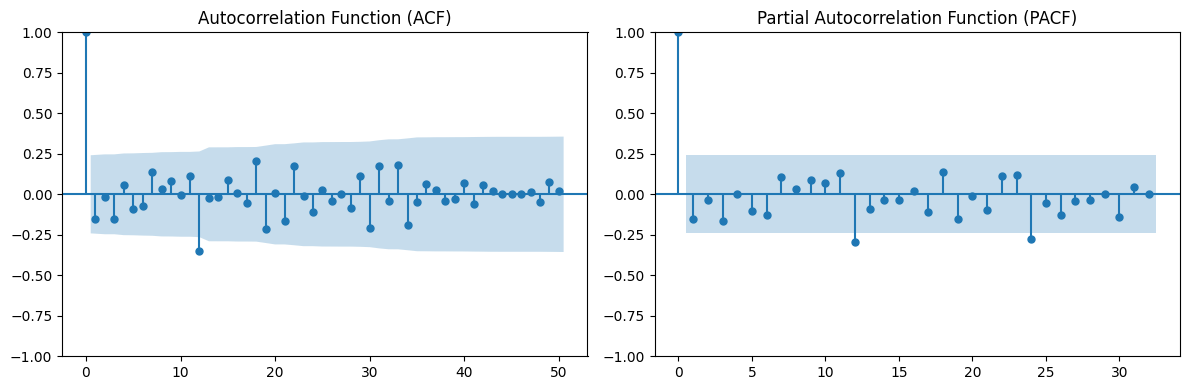

In [56]:
# Create subplots
significance_level = 0.05
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# ACF plot with significant lines
sm.graphics.tsa.plot_acf(resid_panjang['Diff12'].dropna(), lags=50, alpha=significance_level,ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

# PACF plot with significant lines
sm.graphics.tsa.plot_pacf(resid_panjang['Diff12'].dropna(), lags=32, alpha=significance_level,ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()


In [57]:
from statsmodels.tsa.arima.model import ARIMA
model_panjang = ARIMA(model_sm_panjang.resid, order=(0,0,1), seasonal_order=(0,1,1,12)).fit()
model_panjang.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                                y   No. Observations:                   79
Model:             ARIMA(0, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -915.142
Date:                          Tue, 02 Jan 2024   AIC                           1836.283
Time:                                  23:39:59   BIC                           1842.897
Sample:                              01-01-2006   HQIC                          1838.901
                                   - 07-01-2012                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6963      0.170      4.107      0.000       0.364       1.029
ma.S.L12      -0.0909      0.132     -0.689      0.491      -0.350       0.168
sigma2      7.234e+10   2.47e-13   2.93e+23      0.000    7.23e+10    7.23e+10
===================================================================================
Ljung-Box (L1) (Q):                   5.57   Jarque-Bera (JB):               173.33
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                             0.09
Prob(H) (two-sided):                  0.20   Kurtosis:                        10.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.35e+40. Standard errors may be unstable.
"""

In [58]:
forecast = model_panjang.get_forecast(steps=53).summary_frame(alpha=0.05)
e_pred = forecast['mean']
zt_panjang = model_sm_panjang.predict(Y_test)+e_pred
zt_panjang

Waktu
2012-08-01    1.085424e+06
2012-09-01    1.206527e+06
2012-10-01    1.424709e+06
2012-11-01    1.417726e+06
2012-12-01    1.401448e+06
2013-01-01    1.250906e+06
2013-02-01    1.241967e+06
2013-03-01    1.193975e+06
2013-04-01    1.133872e+06
2013-05-01    1.107507e+06
2013-06-01    1.117273e+06
2013-07-01    1.144489e+06
2013-08-01    1.320106e+06
2013-09-01    1.432645e+06
2013-10-01    1.650827e+06
2013-11-01    1.643844e+06
2013-12-01    1.627566e+06
2014-01-01    1.477024e+06
2014-02-01    1.468085e+06
2014-03-01    1.420093e+06
2014-04-01    1.359990e+06
2014-05-01    1.333625e+06
2014-06-01    1.343390e+06
2014-07-01    1.370607e+06
2014-08-01    1.546224e+06
2014-09-01    1.658763e+06
2014-10-01    1.876945e+06
2014-11-01    1.869961e+06
2014-12-01    1.853683e+06
2015-01-01    1.703142e+06
2015-02-01    1.694203e+06
2015-03-01    1.646211e+06
2015-04-01    1.586108e+06
2015-05-01    1.559743e+06
2015-06-01    1.569508e+06
2015-07-01    1.596725e+06
2015-08-01    1.772342

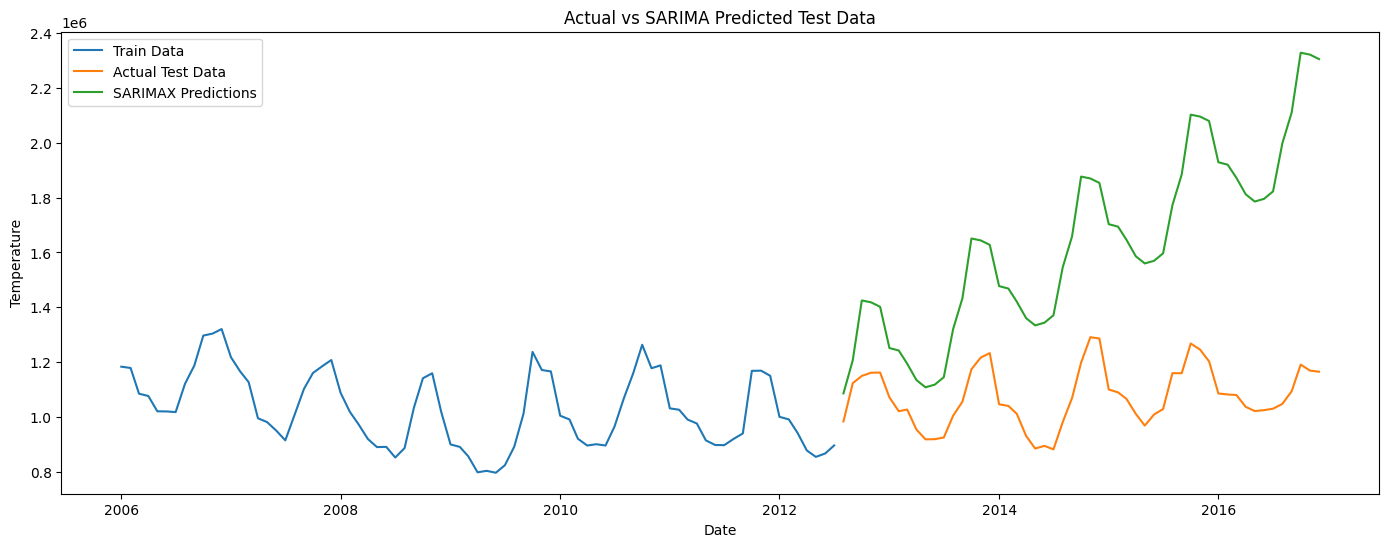

In [59]:
# Pastikan DataFrame diurutkan berdasarkan indeks datetime
train_data_panjang.sort_index(inplace=True)
test_data_panjang.sort_index(inplace=True)

# Mengonversi indeks datetime menjadi array
date_train_panjang = train_data_panjang.index.values
date_test_panjang = test_data_panjang.index.values

# Mengonversi y_train menjadi array
y_train_panjang = train_data_panjang['Jumlah Produksi'].values

# Mengonversi 'temp' dan 'SARIMA Predictions' menjadi array
temp_actual_panjang = test_data_panjang['Jumlah Produksi'].values
zt_panjang = zt_panjang.values

# Menampilkan plot hasil prediksi
plt.figure(figsize=(17, 6))
plt.plot(date_train_panjang, y_train_panjang, label='Train Data')
plt.plot(date_test_panjang, temp_actual_panjang, label='Actual Test Data')
plt.plot(date_test_panjang, zt_panjang, label='SARIMAX Predictions')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Actual vs SARIMA Predicted Test Data')
plt.show()


In [60]:
# Menghitung metrik evaluasi untuk data uji
mse_test_panjang = mean_squared_error(test_data_panjang['Jumlah Produksi'], zt_panjang)
rmse_test_panjang = np.sqrt(mse_test_panjang)
mae_test_panjang = mean_absolute_error(test_data_panjang['Jumlah Produksi'], zt_panjang)
mape_test_panjang = np.mean(np.abs((test_data_panjang['Jumlah Produksi'] - zt_panjang) / test_data_panjang['Jumlah Produksi'])) * 100

# Menampilkan metrik evaluasi
print("\nMetrik evaluasi untuk data uji:")
print(f"MSE: {mse_test_panjang}")
print(f"RMSE: {rmse_test_panjang}")
print(f"MAE: {mae_test_panjang}")
print(f"MAPE: {mape_test_panjang}")



Metrik evaluasi untuk data uji:
MSE: 382258393533.9357
RMSE: 618270.48573738
MAE: 553928.1342839471
MAPE: 51.11154900885923


# Jangka Pendek

In [61]:
# Menambahkan variabel tren
df['Trend'] = np.arange(1, len(df)+1)
train_data_pendek = df.iloc[:110]
test_data_pendek = df.iloc[110:]

In [62]:
# Membuat model regresi linear dengan scikit-learn
X_train = train_data_pendek[['Trend'] + [col for col in df.columns if 'month' in col]]
y_train = train_data_pendek['Jumlah Produksi']
model_sm_pendek = sm.OLS(y_train, X_train.astype(float)).fit()
model_sm_panjang.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:        Jumlah Produksi   R-squared (uncentered):                   0.705
Model:                            OLS   Adj. R-squared (uncentered):              0.701
Method:                 Least Squares   F-statistic:                              186.6
Date:                Tue, 02 Jan 2024   Prob (F-statistic):                    2.17e-22
Time:                        23:39:59   Log-Likelihood:                         -1157.8
No. Observations:                  79   AIC:                                      2318.
Df Residuals:                      78   BIC:                                      2320.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Trend       1.884e+04   1379.249     13.662      0.000    1.61e+04    2.16e+04
==============================================================================
Omnibus:                       11.358   Durbin-Watson:                   0.020
Prob(Omnibus):                  0.003   Jarque-Bera (JB):                3.673
Skew:                           0.134   Prob(JB):                        0.159
Kurtosis:                       1.978   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [63]:
# Membuat prediksi untuk data test
Y_test = test_data_pendek[['Trend'] + [col for col in df.columns if 'month' in col]]
test_data_pendek['Predictions'] = model_sm_pendek.predict(Y_test)

In [64]:
#residual dari time series regression
residual = model_sm_pendek.resid
len(residual)

resid_pendek = pd.DataFrame(residual)
resid_pendek = resid_pendek.rename(columns={0: 'resid_pendek'})
resid_pendek

,resid_pendek
Waktu,
2006-01-01,1.168866e+06
2006-02-01,1.150265e+06
2006-03-01,1.042344e+06
2006-04-01,1.019983e+06
2006-05-01,9.501440e+05
...,...
2014-10-01,-2.810342e+05
2014-11-01,-2.020302e+05
2014-12-01,-2.210712e+05


In [65]:
from statsmodels.tsa import stattools
adf_result = stattools.adfuller(resid_pendek, autolag='AIC')

print(f'p-val of the ADF test: {adf_result}')
if adf_result[1]<0.05:
    print('data stasioner')
else:
    print('data tidak stasioner')

p-val of the ADF test: (-2.0163393098846987, 0.27945515205712435, 12, 97, {'1%': -3.4996365338407074, '5%': -2.8918307730370025, '10%': -2.5829283377617176}, 2364.4258951094826)
data tidak stasioner


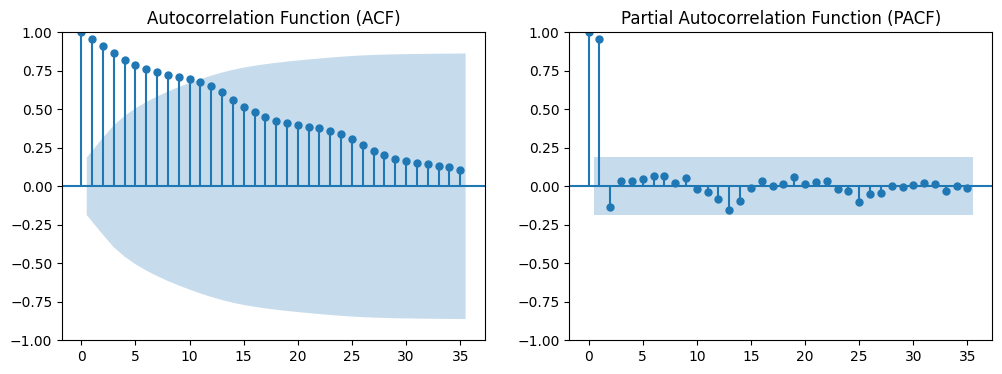

In [66]:
acfresult = sm.tsa.acf(resid_pendek,fft=False)
pacfresult = sm.tsa.pacf(resid_pendek,method='ols')

sl=0.05
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

sm.graphics.tsa.plot_acf(resid_pendek, lags=35, alpha=sl, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

# PACF plot with significant lines 
sm.graphics.tsa.plot_pacf(resid_pendek, lags=35, alpha=sl, ax=ax2) 
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout
plt.show()

In [67]:
# Diferensiasi sederhana
resid_pendek['Diff'] = resid_pendek['resid_pendek'].diff(1)
resid_pendek['Diff12'] = resid_pendek['resid_pendek'].diff(1).diff(12)

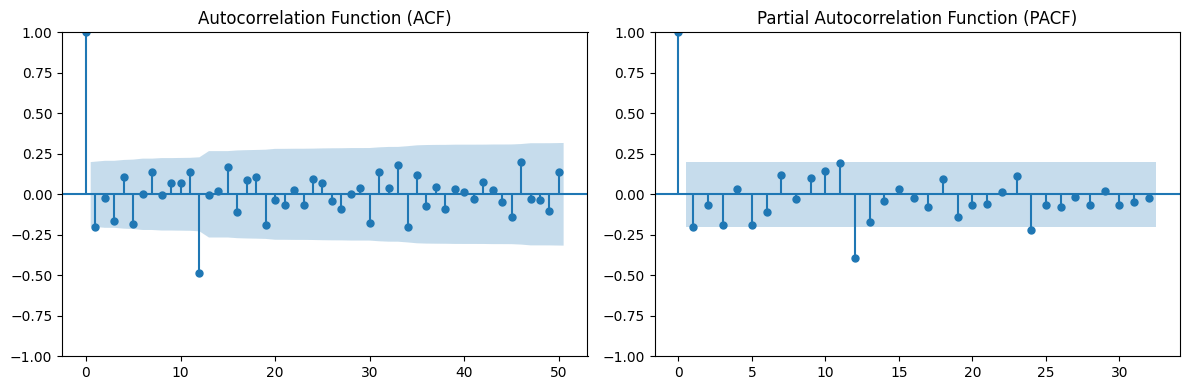

In [68]:
# Create subplots
significance_level = 0.05
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# ACF plot with significant lines
sm.graphics.tsa.plot_acf(resid_pendek['Diff12'].dropna(), lags=50, alpha=significance_level,ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

# PACF plot with significant lines
sm.graphics.tsa.plot_pacf(resid_pendek['Diff12'].dropna(), lags=32, alpha=significance_level,ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()


In [69]:
from statsmodels.tsa.arima.model import ARIMA
model_pendek = ARIMA(model_sm_pendek.resid, order=(0,0,1), seasonal_order=(0,1,1,12)).fit()
model_pendek.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                                y   No. Observations:                  110
Model:             ARIMA(0, 0, 1)x(0, 1, 1, 12)   Log Likelihood               -1309.094
Date:                          Tue, 02 Jan 2024   AIC                           2624.188
Time:                                  23:40:01   BIC                           2631.943
Sample:                              01-01-2006   HQIC                          2627.325
                                   - 02-01-2015                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6407      0.109      5.901      0.000       0.428       0.853
ma.S.L12      -0.0952      0.079     -1.207      0.227      -0.250       0.059
sigma2      3.763e+10   3.61e-13   1.04e+23      0.000    3.76e+10    3.76e+10
===================================================================================
Ljung-Box (L1) (Q):                   3.19   Jarque-Bera (JB):               241.88
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               0.36   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.56e+38. Standard errors may be unstable.
"""

In [70]:
forecast = model_pendek.get_forecast(steps=22).summary_frame(alpha=0.05)
e_pred = forecast['mean']
zt_pendek= model_sm_pendek.predict(Y_test)+e_pred
zt_pendek

Waktu
2015-03-01    1.140835e+06
2015-04-01    1.116648e+06
2015-05-01    1.071745e+06
2015-06-01    1.080555e+06
2015-07-01    1.069831e+06
2015-08-01    1.167751e+06
2015-09-01    1.252872e+06
2015-10-01    1.380176e+06
2015-11-01    1.468050e+06
2015-12-01    1.464833e+06
2016-01-01    1.279579e+06
2016-02-01    1.269170e+06
2016-03-01    1.313531e+06
2016-04-01    1.284048e+06
2016-05-01    1.239145e+06
2016-06-01    1.247955e+06
2016-07-01    1.237231e+06
2016-08-01    1.335150e+06
2016-09-01    1.420272e+06
2016-10-01    1.547576e+06
2016-11-01    1.635450e+06
2016-12-01    1.632233e+06
dtype: float64

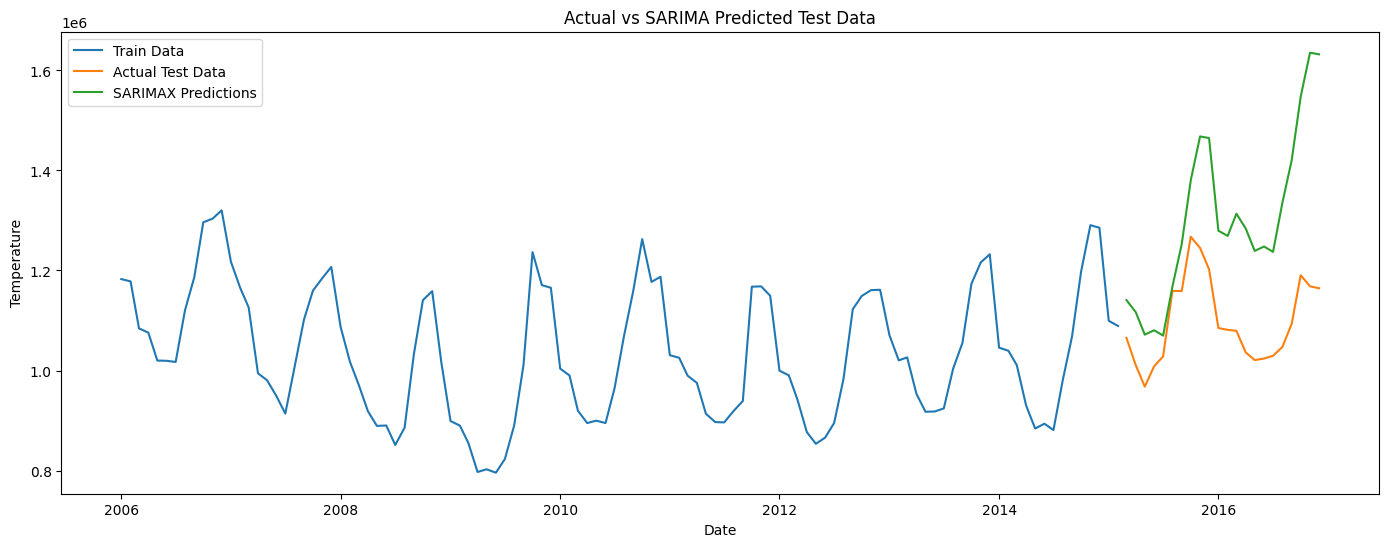

In [73]:
# Pastikan DataFrame diurutkan berdasarkan indeks datetime
train_data_pendek.sort_index(inplace=True)
test_data_pendek.sort_index(inplace=True)

# Mengonversi indeks datetime menjadi array
date_train_pendek = train_data_pendek.index.values
date_test_pendek = test_data_pendek.index.values

# Mengonversi y_train menjadi array
y_train_pendek = train_data_pendek['Jumlah Produksi'].values

# Mengonversi 'temp' dan 'SARIMA Predictions' menjadi array
temp_actual_pendek = test_data_pendek['Jumlah Produksi'].values
zt_panjang = zt_panjang

# Menampilkan plot hasil prediksi
plt.figure(figsize=(17, 6))
plt.plot(date_train_pendek, y_train_pendek, label='Train Data')
plt.plot(date_test_pendek, temp_actual_pendek, label='Actual Test Data')
plt.plot(date_test_pendek, zt_pendek, label='SARIMAX Predictions')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Actual vs SARIMA Predicted Test Data')
plt.show()


In [74]:
# Menghitung metrik evaluasi untuk data uji
mse_test_pendek = mean_squared_error(test_data_pendek['Jumlah Produksi'], zt_pendek)
rmse_test_pendek = np.sqrt(mse_test_pendek)
mae_test_pendek = mean_absolute_error(test_data_pendek['Jumlah Produksi'], zt_pendek)
mape_test_pendek = np.mean(np.abs((test_data_pendek['Jumlah Produksi'] - zt_pendek) / test_data_pendek['Jumlah Produksi'])) * 100

# Menampilkan metrik evaluasi
print("\nMetrik evaluasi untuk data uji:")
print(f"MSE: {mse_test_pendek}")
print(f"RMSE: {rmse_test_pendek}")
print(f"MAE: {mae_test_pendek}")
print(f"MAPE: {mape_test_pendek}")



Metrik evaluasi untuk data uji:
MSE: 57253255191.92449
RMSE: 239276.5245316065
MAE: 205517.19978619783
MAPE: 18.587080658779893
